Most of the data cleaning occurs in the cell below.

C:\Users\david\anaconda3_2\python.exe
                 ride_id  rideable_type           started_at  \
0       3CB26DA7B86F34E7  electric_bike  2023-10-02 18:49:43   
1       09950211363C6DEA   classic_bike  2023-10-14 20:35:28   
2       A97914CD757A75F0   classic_bike  2023-10-01 11:54:35   
3       1780A2A28E05BC38   classic_bike  2023-10-09 17:14:39   
4       59C53397D20C3A4C   classic_bike  2023-10-20 16:25:00   
...                  ...            ...                  ...   
537103  62A15B630F8F272A   classic_bike  2023-10-05 13:59:29   
537104  3ADAD751D4A363BE   classic_bike  2023-10-19 18:56:37   
537105  3C28D52972982DD9  electric_bike  2023-10-04 08:23:27   
537106  8167A148A9DB1F0D  electric_bike  2023-10-17 21:28:18   
537107  4890C7A2709D4469   classic_bike  2023-10-22 16:29:07   

                   ended_at                 start_station_name  \
0       2023-10-02 18:59:51         Ashland Ave & Blackhawk St   
1       2023-10-14 20:46:18           Southport Ave & Clark S

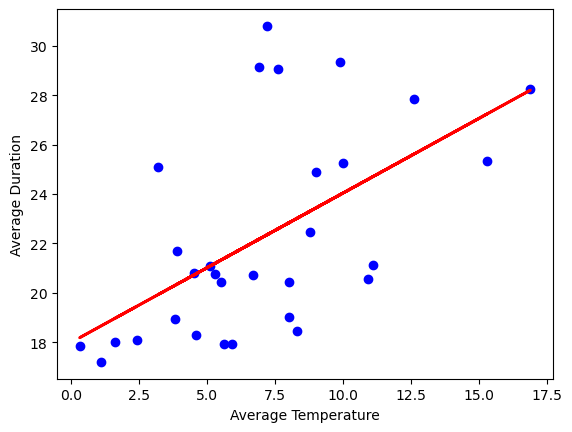

actual values of mean temp in C [25.32771055 18.06985456 20.4475084  29.16016308 17.9264044  21.68913603]
predicted values of mean temp in C [27.12272398 18.645309   20.68251725 21.60254678 20.74823364 19.63105492]


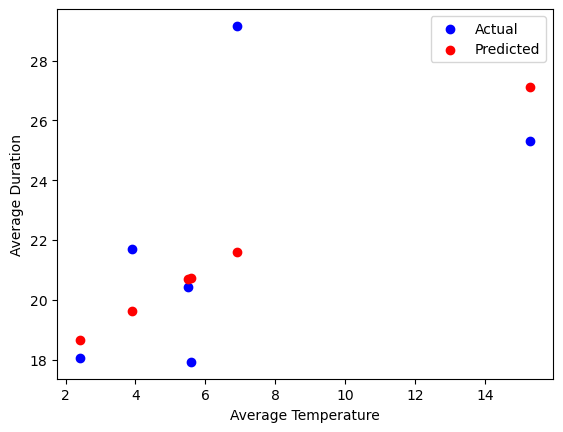

In [3]:
# Author David Miszczyk, CS 418 Fall 2023
import pandas as pd
import sys
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

print(sys.executable)

# Set the display option to show all columns
pd.set_option('display.max_columns', None)

df = pd.read_csv("DivvyBikes_for_418-2.csv",sep=',', low_memory=False)

bd = pd.read_csv('bike_data.zip', compression='zip') # 10-2023 Divvy data

print(bd)

avg_temp = pd.read_csv("weather_data.csv", skiprows=2)

avg_temp.rename(columns={'time': 'date'}, inplace=True) # rename 'time' to 'date' column

df['ended_at'] = pd.to_datetime(df['ended_at'])
df['started_at'] = pd.to_datetime(df['started_at'])

# Calculate ride duration in seconds
df['duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds()/60

# clean duration column to remove anything longer than 24 hours.(1440 minutes)
df = df[df['duration'] <= 1440]

# Extract date from 'started_at'
df['date'] = df['started_at'].dt.date

# Calculate average duration for each day
avg_duration = df.groupby('date')['duration'].mean()

# Convert the 'avg_duration' Series into a DataFrame
avg_duration = avg_duration.reset_index()

avg_duration.columns = ['date', 'avg_duration']

print("avg_duration", avg_duration.columns)

print("avg_temp", avg_temp.columns)

# Convert the 'date' columns to datetime
avg_temp['date'] = pd.to_datetime(avg_temp['date'])

avg_duration['date'] = pd.to_datetime(avg_duration['date'])

# Merge the dataframes on 'date'
merged_df = pd.merge(avg_temp, avg_duration, on='date')

# Now you can perform linear regression on the merged dataframe
X = merged_df['temperature_2m_mean (°C)'].values.reshape(-1,1) # reshaping for sklearn compatibility

y = merged_df['avg_duration'].values

# Create a LinearRegression object
lm = LinearRegression()

lm.fit(X,y)

# Now, you can see the parameters of your fitted model
print('Intercept: \n', lm.intercept_)
print('Coefficients: \n', lm.coef_)

r_squared = lm.score(X, y)

print('R-squared: ', r_squared) # check R^2 value

# Plot the equation of the line and data points given by the Linear Regression.
plt.scatter(merged_df['temperature_2m_mean (°C)'], merged_df['avg_duration'], color='blue')
plt.xlabel('Average Temperature')
plt.ylabel('Average Duration')

# Plotting the regression line
predicted_values = lm.predict(X)
plt.plot(merged_df['temperature_2m_mean (°C)'], predicted_values, color='red', linewidth=2)

plt.show()

# Assuming X is your feature set and y is your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a SVR object
svr = SVR(kernel='linear')

# Train the model using the training sets
svr.fit(X_train, y_train)

# Now, you can use the trained model to predict the test data
y_pred = svr.predict(X_test)

print("actual values of mean temp in C", y_test)
print("predicted values of mean temp in C", y_pred)

# Scatter plot of the actual vs predicted values for the SVM.
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred, color='red', label='Predicted')
plt.xlabel('Average Temperature')
plt.ylabel('Average Duration')
plt.legend()
plt.show()

The linear regression predicts a continuous outcome variable, y, from one or more predictor variables x. It assumes a linear relationship between x and y. In our case, the y shall be the average duration of Divvy rides taken by customers and x shall be the temperature variable. We proceed using several different Python libraries to generate model training, model evaluation, hypothesis testing. First, we get the historal weather data using the Open-Mateo APi to match the days of our Divvy rides dataset. The weather data was somewhat cleaned and put into a list in the temp() function. I may need to use this resource in the future; https://open-meteo.com/en/docs/historical-weather-api